# E proviamoci dai!


In [25]:
pip install facenet-pytorch

In [26]:
import torch
from matplotlib import pyplot as plt
from torchvision import datasets, models
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import numpy as np
import collections
import PIL.Image
from torch.utils.data import DataLoader, Subset
import os
import random
from google.colab import drive
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import glob
import shutil
from facenet_pytorch import MTCNN
# from pathlib import Path

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [28]:
drive.mount("/content/drive")
root_dir = "/content/drive/My Drive/IA_Project"
data_path = os.path.join(root_dir, "LFW_DIR")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# iperparametri
img_size = 224
crop_size = 128
batch_size = 130

In [30]:
# image transformation

norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)
#norm_mean = (0.5, 0.5, 0.5)
#norm_std = (0.5, 0.5, 0.5)

test_transform = T.Compose([
    T.Resize(img_size),
    T.CenterCrop(crop_size),
    T.ToTensor(),
    T.Normalize(norm_mean, norm_std),
])

train_transform = T.Compose([
    T.Resize(img_size),
    T.RandomCrop(crop_size),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(norm_mean, norm_std),
])

In [31]:
# Funzione per bilanciare il dataset
def balance_dataset(data_path):
  people_paths = glob.glob(os.path.join(data_path, "*")) #lista dei path delle directory
  print(len(people_paths))

  #ciclo le directory contenute nella root
  for path in people_paths:
    directory = glob.glob(os.path.join(path, "*")) #lista dei path degli elementi contenuti nella directory corrente

    if len(directory) < 5:
      shutil.rmtree(path)
    images_list = []
    for image in directory:
      images_list.append(image)
    for i in range(5, len(images_list)):
      os.remove(images_list[i]) #rimuovo le immagini in eccesso

  return 

In [32]:
balance_dataset(data_path)

423


Serve ora dividere il dataset nei tre da utilizzare per il training, il testing e la validation

In [33]:
# per cominciare ricavo un dizionario del tipo {label: [path immagine]}
def get_dict(data_path):
  people_paths = glob.glob(os.path.join(data_path, "*"))
  label = 0
  my_dict = {}

  for path in people_paths:
    directory = glob.glob(os.path.join(path, "*"))
    for item in directory:
      my_dict[item] = label
    label += 1

  return my_dict

In [34]:
my_dict = get_dict(data_path)
print(len(my_dict))

2115


In [35]:
list_item = list(my_dict.items())
random.shuffle(list_item)
list_item_rand = dict(list_item)

# Dataset fraction
test_frac = 0.2
val_frac = 0.2

# data len
num_data = len(my_dict)
num_test = int(num_data*test_frac)
num_val = int(num_data*val_frac)

# split dict in train, test, val
num_data = num_data - num_test
test_items = dict(list(list_item_rand.items())[num_data:]) 
list_item_rand = dict(list(list_item_rand.items())[:num_data])

num_data = num_data - num_val
val_items = dict(list(list_item_rand.items())[num_data:]) 
train_items = dict(list(list_item_rand.items())[:num_data])

In [36]:
print(f" number of train samples: {len(train_items)}\n",
      f"number of val samples: {len(val_items)}\n",
      f"number if test samples: {len(test_items)}")

 number of train samples: 1269
 number of val samples: 423
 number if test samples: 423


In [37]:
detector = MTCNN(select_largest=False)

In [48]:
class LFWDataset(torch.utils.data.Dataset):

  def __init__(self, class_images_dict, detector, transform=None):
    self.transform = transform
    self.detector = detector
    self.class_images_dict = class_images_dict
    self.list_of_tuples = self.get_list_of_tuples(self.class_images_dict)

  # serve dopo per il getitem
  def get_list_of_tuples(self, class_images_dict):
    list_of_tuples = [(k, v) for k, v in class_images_dict.items()] 
    return list_of_tuples
    
  def __len__(self):
    return len(self.list_of_tuples)

  def __getitem__(self, index):
    img_path, label = self.list_of_tuples[index]
    img = PIL.Image.open(img_path)
    face = self.detector(img)

    if self.transform:
      face = self.transform(face)

    return face, label

In [49]:
# get datasets
train_dataset = LFWDataset(train_items, detector=detector, transform=train_transform)
test_dataset = LFWDataset(test_items, detector=detector, transform=test_transform)
val_dataset = LFWDataset(val_items, detector=detector, transform=train_transform)

num_train = len(train_dataset)
num_test = len(test_dataset)
num_val = len(val_dataset)

print(f"Num. training samples: {num_train}")
print(f"Num. test samples: {num_test}")
print(f"Num. val samples: {num_val}")

Num. training samples: 1269
Num. test samples: 423
Num. val samples: 423


In [40]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

In [41]:
def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    dot_product = torch.matmul(embeddings, embeddings.t())

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = torch.diag(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = square_norm.unsqueeze(0) - 2.0 * dot_product + square_norm.unsqueeze(1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances[distances < 0] = 0

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = distances.eq(0).float()
        distances = distances + mask * 1e-16

        distances = (1.0 -mask) * torch.sqrt(distances)

    return distances

In [42]:
def _get_anchor_positive_triplet_mask(labels, device):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = torch.eye(labels.size(0)).bool().to(device)
    indices_not_equal = ~indices_equal

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)

    return labels_equal & indices_not_equal

In [43]:
def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)

    return ~(labels.unsqueeze(0) == labels.unsqueeze(1))

In [44]:
def batch_hard_triplet_loss(labels, embeddings, margin, squared=False, device='cpu'):
    """Build the triplet loss over a batch of embeddings.

    For each anchor, we get the hardest positive and hardest negative to form a triplet.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels, device).float()

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = mask_anchor_positive * pairwise_dist

    # shape (batch_size, 1)
    hardest_positive_dist, _ = anchor_positive_dist.max(1, keepdim=True)

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist, _ = pairwise_dist.max(1, keepdim=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist, _ = anchor_negative_dist.min(1, keepdim=True)

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    tl = hardest_positive_dist - hardest_negative_dist + margin
    tl[tl < 0] = 0
    triplet_loss = tl.mean()

    return triplet_loss

In [45]:
# download di resnet34
model = models.resnet34(pretrained=False)
model = model.to(device)

In [46]:
def trainLoop(epochs, device, model, lr=0.001):

  # model.eval()
  model.to(device) # model è definito sopra

  #optimizer = optim.Adam(model.parameters(), lr=lr)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)

  # initialize loss and accuracy values
  history_loss = {"train": [], "val": [], "test": []}
  history_accuracy = {"train": [], "val": [], "test": []}
  best_val_accuracy = 0
  test_accuracy_at_best_val = 0

  try:

    for epoch in range(epochs):
      sum_loss = {"train": 0, "val": 0, "test": 0}
      loss_count = {"train": 0, "val": 0, "test": 0}
      sum_accuracy = {"train": 0, "val": 0, "test": 0}
      accuracy_count = {"train": 0, "val": 0, "test": 0}

      for split in ["train", "val", "test"]:
        if split == 'train':
          model.train()
          torch.set_grad_enabled(True)
        else:
          model.eval()
          torch.set_grad_enabled(False)
        for (anchor_imgs, anchor_labels) in loaders[split]:
          # Move to CUDA
          anchor_imgs = anchor_imgs.to(device)
          anchor_labels = anchor_labels.to(device)
          
          # Compute output
          anchors_out = model(anchor_imgs)
          # Compute Loss
          loss = batch_hard_triplet_loss(anchor_labels, anchors_out, margin=0.2, device=device)
          # Update loss
          sum_loss[split] += loss.item()
          loss_count[split] += 1
          # Compute accuracy 
          pred_labels = anchors_out.argmax(1)
          # print(pred_labels)
          correct = pred_labels.eq(anchor_labels).sum().item()
          # print(correct)
          batch_accuracy = correct/anchor_imgs.size(0) # potremmo provare a mettere anchor_imgs.size(1)
          sum_accuracy[split] += batch_accuracy
          accuracy_count[split] += 1

          if split == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


      # Compute epoch loss
      epoch_loss = {split: sum_loss[split]/loss_count[split] for split in ["train", "val", "test"]}
      epoch_accuracy = {split: sum_accuracy[split]/accuracy_count[split] for split in ["train", "val", "test"]}
      # Update history
      for split in ["train", "val", "test"]:
        history_loss[split].append(epoch_loss[split])
        history_accuracy[split].append(epoch_accuracy[split])

      # Print info
      print("------------------------------------------------------------------")
      print(f"Epoch {epoch+1}:",
            f"TrL={epoch_loss['train']:.4f},",
            f"TrA={epoch_accuracy['train']:.4f},",
            f"VL={epoch_loss['val']:.4f},",
            f"VA={epoch_accuracy['val']:.4f},",
            f"TeL={epoch_loss['test']:.4f},",
            f"TeA={epoch_accuracy['test']:.4f},")
      print("------------------------------------------------------------------")

      if epoch_accuracy['val'] > best_val_accuracy:
        best_val_accuracy = epoch_accuracy['val']
        test_accuracy_at_best_val = epoch_accuracy['test']

  except KeyboardInterrupt:
      print("Interrupted")
  finally:
      print(f"Final val accuracy: {best_val_accuracy:.4f}")
      print(f"Final test accuracy: {test_accuracy_at_best_val:.4f}")
      # Plot loss
      plt.title("Loss")
      for split in ["train", "val", "test"]:
        plt.plot(history_loss[split], label=split)
      plt.legend()
      plt.show()
      # Plot accuracy
      plt.title("Accuracy")
      for split in ["train", "val", "test"]:
        plt.plot(history_accuracy[split], label=split)
      plt.legend()
      plt.show()

Final val accuracy: 0.0000
Final test accuracy: 0.0000


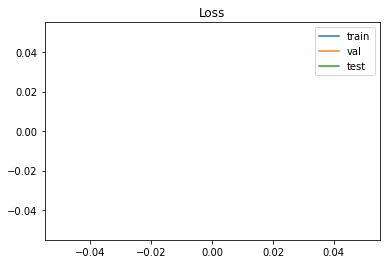

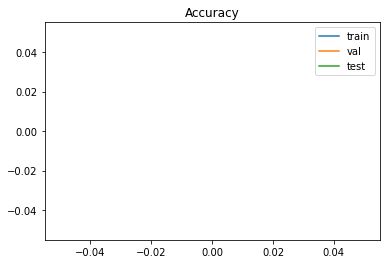

TypeError: ignored

In [50]:
trainLoop(100, device, model, lr=0.0001)